# Anomlay Detection with MV Tech AD Dataset

In [ ]:
import os
import random
from collections import Counter

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from torchvision import models
from torchvision.models import efficientnet_b0

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("사용 중인 디바이스:", device)

사용 중인 디바이스: cuda


In [ ]:
batch_size = 16
num_epochs = 10
learning_rate = 1e-4

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Dataset


In [ ]:
def visualize_data_distribution_by_category(root_dir):
    """
    Visualize the class distribution in the MVTecAD dataset by major categories.

    Parameters:
    - root_dir (str): Path to the root directory of the dataset.
    """
    data = []
    labels = []

    # Traverse the dataset folder
    for data_type in os.listdir(root_dir):  # e.g., 'bottle', 'cable', etc.
        data_type_path = os.path.join(root_dir, data_type)
        if os.path.isdir(data_type_path):
            test_path = os.path.join(data_type_path, "test")
            if os.path.exists(test_path):
                for label_folder in os.listdir(test_path):  # e.g., 'broken_large', 'good'
                    label_path = os.path.join(test_path, label_folder)
                    if os.path.isdir(label_path):
                        for image_file in os.listdir(label_path):  # All images in the folder
                            if image_file.endswith((".png", ".jpg", ".jpeg")):
                                # Create combined label: e.g., 'bottle_broken_large'
                                combined_label = f"{data_type}_{label_folder}"
                                data.append(image_file)
                                labels.append((data_type, combined_label))

    # Group data by major categories
    category_data = {}
    for data_type, label in labels:
        if data_type not in category_data:
            category_data[data_type] = []
        category_data[data_type].append(label)

    # Generate plots for each category
    for category, category_labels in category_data.items():
        label_counts = Counter(category_labels)
        class_names = list(label_counts.keys())
        counts = list(label_counts.values())

        # Adjust the figure size based on class count, with a minimum width
        num_classes = len(class_names)
        fig_width = max(6, num_classes * 0.7)  # Ensure a minimum width of 6
        plt.figure(figsize=(fig_width, 6))  # Adjust width for more spacing

        x_positions = np.arange(num_classes)
        plt.bar(x_positions, counts, color='skyblue')
        plt.xticks(x_positions, class_names, fontsize=10, rotation=45, ha='right')  # Larger font size
        plt.ylabel("Number of Samples", fontsize=12)
        plt.xlabel("Class Labels", fontsize=12)
        plt.title(f"{category} Class Distribution (Total: {sum(counts)} samples)", fontsize=14)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        # Print class distribution and total samples
        print(f"Class Distribution for {category}:")
        for class_name, count in label_counts.items():
            print(f"  {class_name}: {count} samples")
        print(f"Total Samples in {category}: {sum(counts)}\n")


### Data visualization

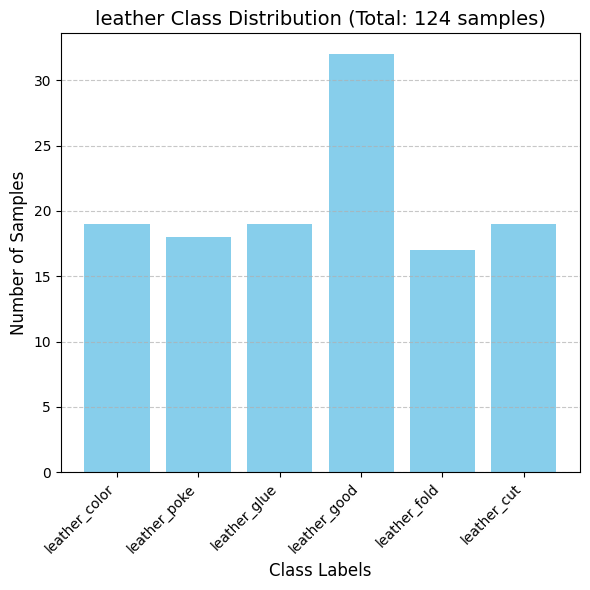

Class Distribution for leather:
  leather_color: 19 samples
  leather_poke: 18 samples
  leather_glue: 19 samples
  leather_good: 32 samples
  leather_fold: 17 samples
  leather_cut: 19 samples
Total Samples in leather: 124



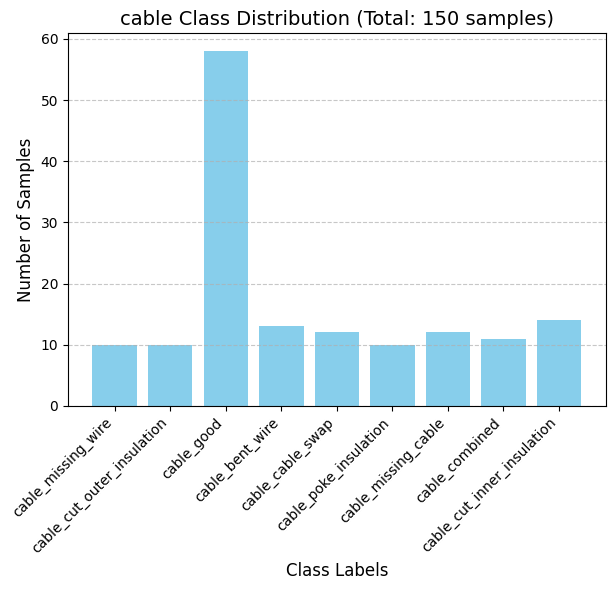

Class Distribution for cable:
  cable_missing_wire: 10 samples
  cable_cut_outer_insulation: 10 samples
  cable_good: 58 samples
  cable_bent_wire: 13 samples
  cable_cable_swap: 12 samples
  cable_poke_insulation: 10 samples
  cable_missing_cable: 12 samples
  cable_combined: 11 samples
  cable_cut_inner_insulation: 14 samples
Total Samples in cable: 150



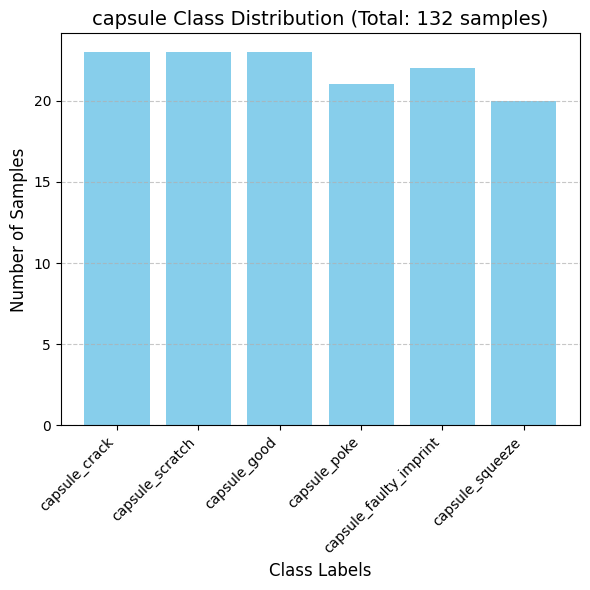

Class Distribution for capsule:
  capsule_crack: 23 samples
  capsule_scratch: 23 samples
  capsule_good: 23 samples
  capsule_poke: 21 samples
  capsule_faulty_imprint: 22 samples
  capsule_squeeze: 20 samples
Total Samples in capsule: 132



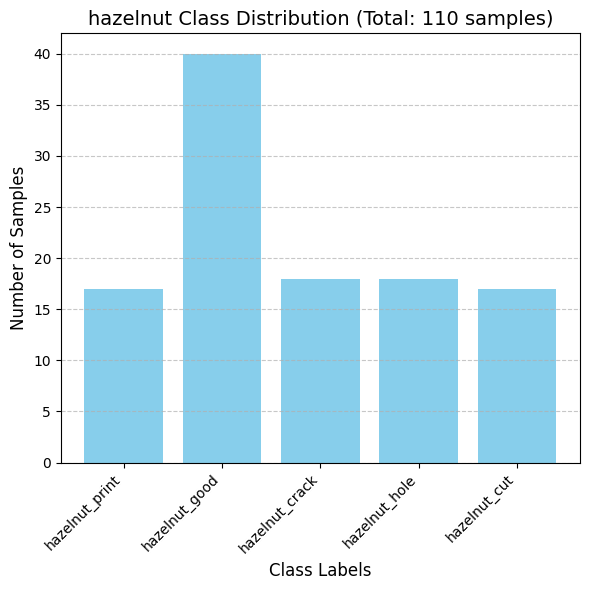

Class Distribution for hazelnut:
  hazelnut_print: 17 samples
  hazelnut_good: 40 samples
  hazelnut_crack: 18 samples
  hazelnut_hole: 18 samples
  hazelnut_cut: 17 samples
Total Samples in hazelnut: 110



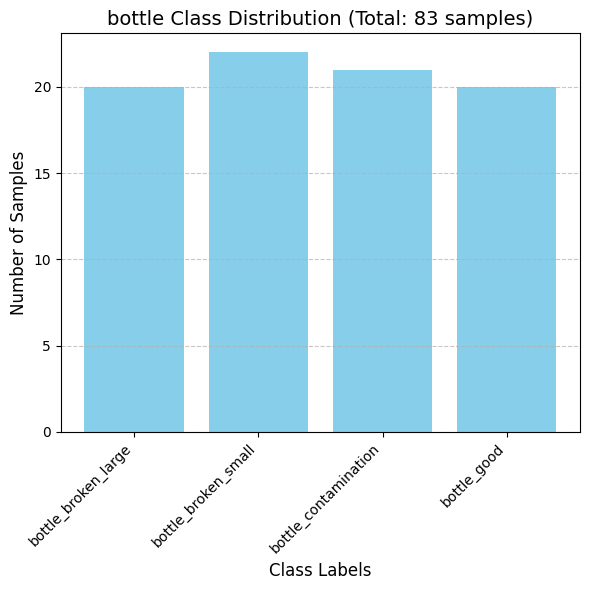

Class Distribution for bottle:
  bottle_broken_large: 20 samples
  bottle_broken_small: 22 samples
  bottle_contamination: 21 samples
  bottle_good: 20 samples
Total Samples in bottle: 83



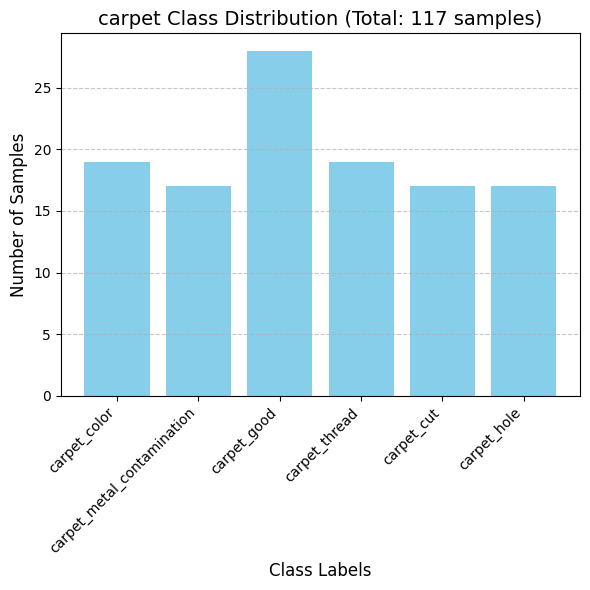

Class Distribution for carpet:
  carpet_color: 19 samples
  carpet_metal_contamination: 17 samples
  carpet_good: 28 samples
  carpet_thread: 19 samples
  carpet_cut: 17 samples
  carpet_hole: 17 samples
Total Samples in carpet: 117



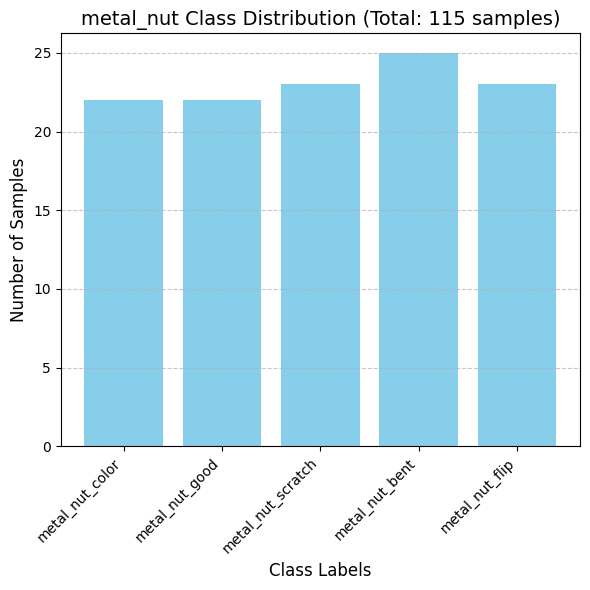

Class Distribution for metal_nut:
  metal_nut_color: 22 samples
  metal_nut_good: 22 samples
  metal_nut_scratch: 23 samples
  metal_nut_bent: 25 samples
  metal_nut_flip: 23 samples
Total Samples in metal_nut: 115



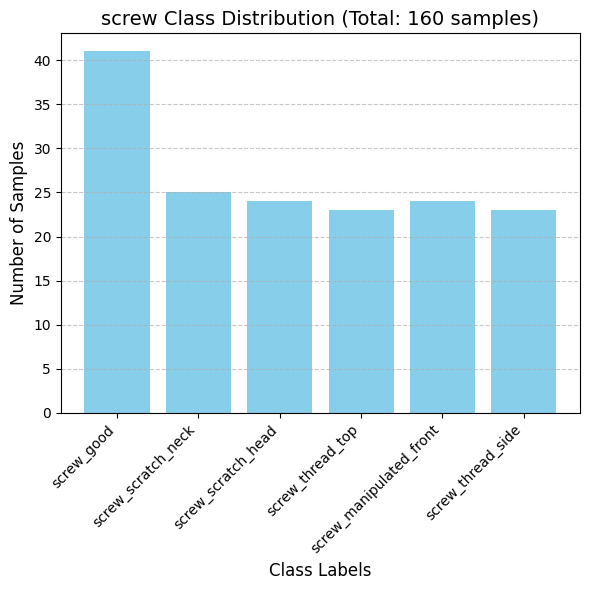

Class Distribution for screw:
  screw_good: 41 samples
  screw_scratch_neck: 25 samples
  screw_scratch_head: 24 samples
  screw_thread_top: 23 samples
  screw_manipulated_front: 24 samples
  screw_thread_side: 23 samples
Total Samples in screw: 160



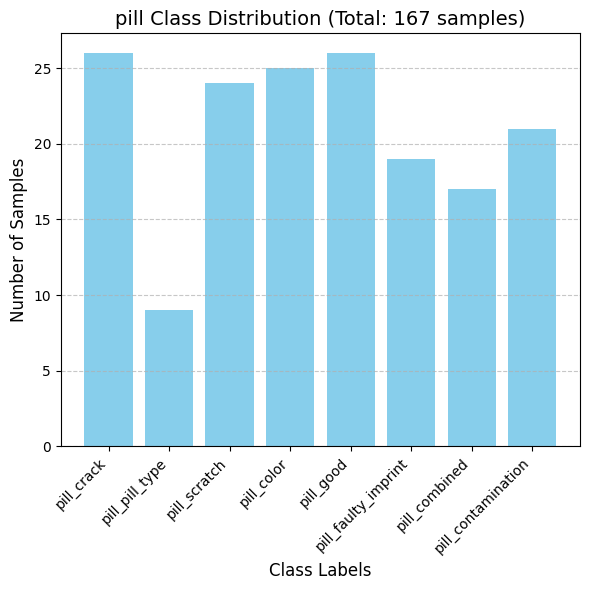

Class Distribution for pill:
  pill_crack: 26 samples
  pill_pill_type: 9 samples
  pill_scratch: 24 samples
  pill_color: 25 samples
  pill_good: 26 samples
  pill_faulty_imprint: 19 samples
  pill_combined: 17 samples
  pill_contamination: 21 samples
Total Samples in pill: 167



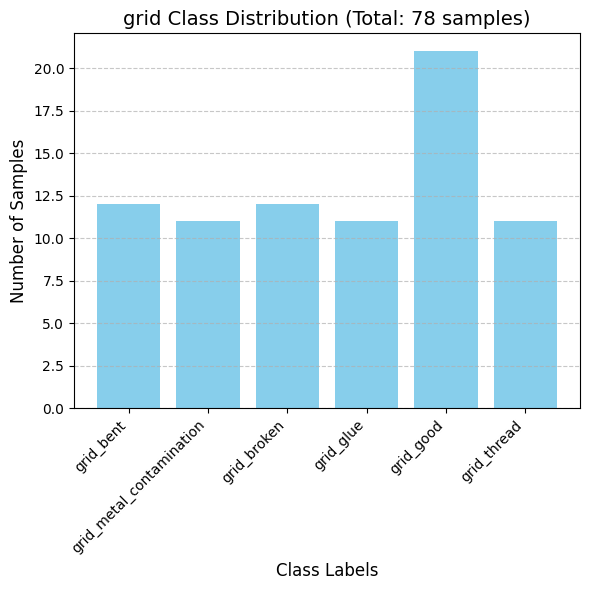

Class Distribution for grid:
  grid_bent: 12 samples
  grid_metal_contamination: 11 samples
  grid_broken: 12 samples
  grid_glue: 11 samples
  grid_good: 21 samples
  grid_thread: 11 samples
Total Samples in grid: 78



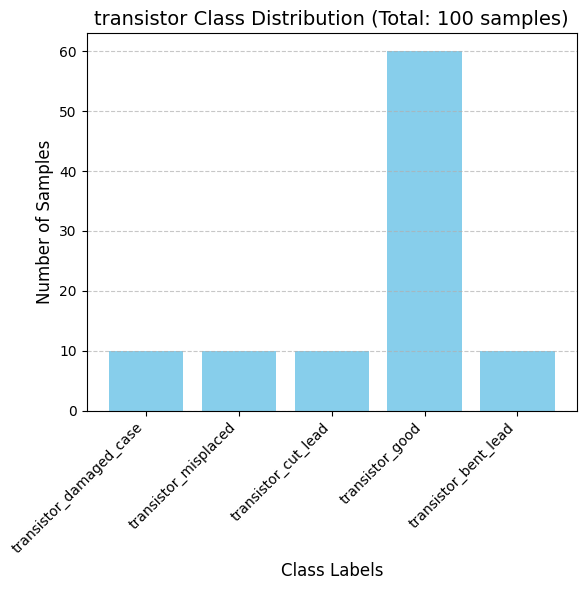

Class Distribution for transistor:
  transistor_damaged_case: 10 samples
  transistor_misplaced: 10 samples
  transistor_cut_lead: 10 samples
  transistor_good: 60 samples
  transistor_bent_lead: 10 samples
Total Samples in transistor: 100



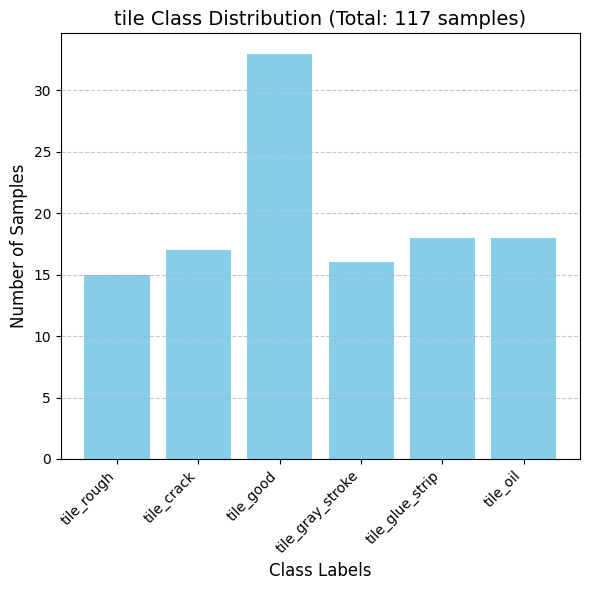

Class Distribution for tile:
  tile_rough: 15 samples
  tile_crack: 17 samples
  tile_good: 33 samples
  tile_gray_stroke: 16 samples
  tile_glue_strip: 18 samples
  tile_oil: 18 samples
Total Samples in tile: 117



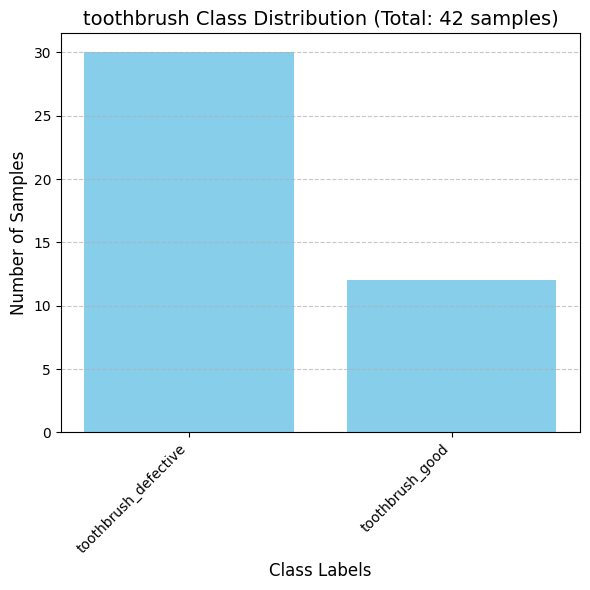

Class Distribution for toothbrush:
  toothbrush_defective: 30 samples
  toothbrush_good: 12 samples
Total Samples in toothbrush: 42



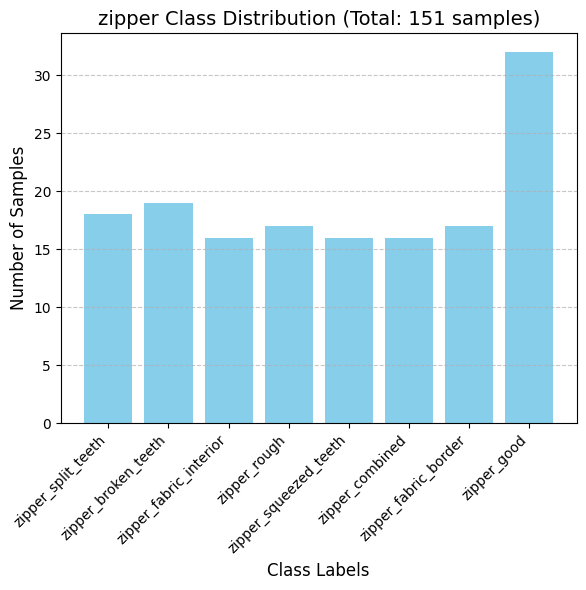

Class Distribution for zipper:
  zipper_split_teeth: 18 samples
  zipper_broken_teeth: 19 samples
  zipper_fabric_interior: 16 samples
  zipper_rough: 17 samples
  zipper_squeezed_teeth: 16 samples
  zipper_combined: 16 samples
  zipper_fabric_border: 17 samples
  zipper_good: 32 samples
Total Samples in zipper: 151



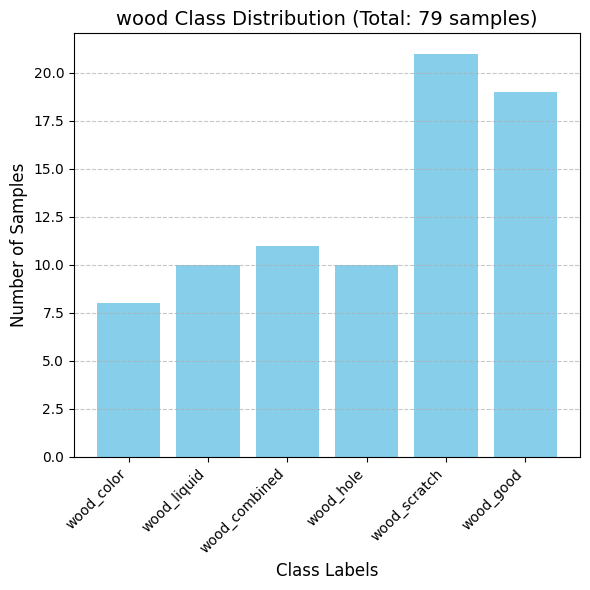

Class Distribution for wood:
  wood_color: 8 samples
  wood_liquid: 10 samples
  wood_combined: 11 samples
  wood_hole: 10 samples
  wood_scratch: 21 samples
  wood_good: 19 samples
Total Samples in wood: 79



In [ ]:
dataset_path = "/content/drive/MyDrive/dataset/MVTecAD"  # Replace with your dataset path
visualize_data_distribution_by_category(dataset_path)